# Diabetes Dataset
https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.regularizers import l1
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import import_ipynb
from functions import *
from time import time

importing Jupyter notebook from functions.ipynb


In [2]:
data = pd.read_csv('data/diabetes.csv', header=0)
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Data Preprocessing
---

### Reformatting Missing Values for Interpolation
Denoted in 'BMI', 'Insulin', 'SkinThickness', 'BloodPressure', and 'Glucose' columns with a 0 value

In [4]:
# data = data.replace({
#     'BMI': {0:np.nan},
#     'Insulin': {0:np.nan},
#     'SkinThickness': {0:np.nan},
#     'Glucose': {0:np.nan},
#     'BloodPressure': {0:np.nan}}# 
#})

In [5]:
# if data.isna().sum().sum() == 0:
#     print('No missing values present')
# else: 
#     print('NaN values across entire dataset: ', data.isna().sum().sum())

In [6]:
#Linear interpolation
# if (data.isna().sum().sum() != 0):
#     data = data.interpolate() 

#Delete missing data
data = data[(data['BMI'] != 0) & (data['Insulin'] != 0) & (data['SkinThickness'] != 0) & (data['Glucose'] != 0)]

In [7]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
753,0,181,88,44,510,43.3,0.222,26,1
755,1,128,88,39,110,36.5,1.057,37,1
760,2,88,58,26,16,28.4,0.766,22,0
763,10,101,76,48,180,32.9,0.171,63,0


## Data Evaluation
---

### Heatmap
Feature Colliniearity
- *No significant multicolliniearity observed - L1 regularization ideal*

Text(0.5, 1.0, 'Diabetes Dataset Colliniearity')

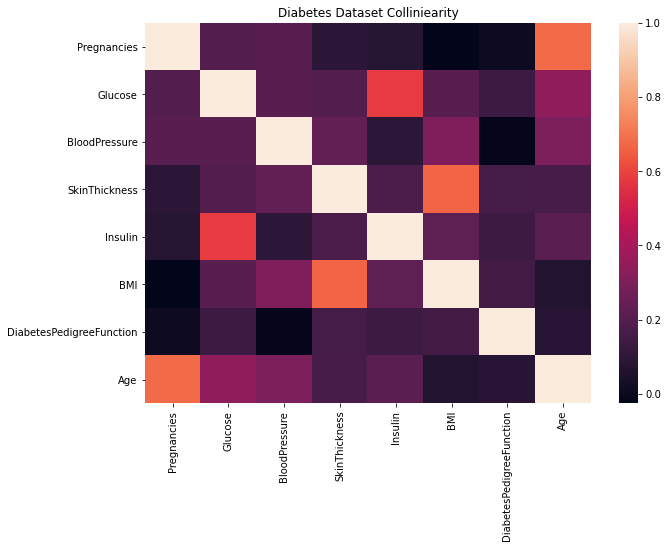

In [8]:
corr = data.loc[:, data.columns != 'Outcome'].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr)
plt.title('Diabetes Dataset Colliniearity')

### Histogram
Feature Distributions

Text(0.5, 0.92, 'Diabetes Dataset Feature Distributions')

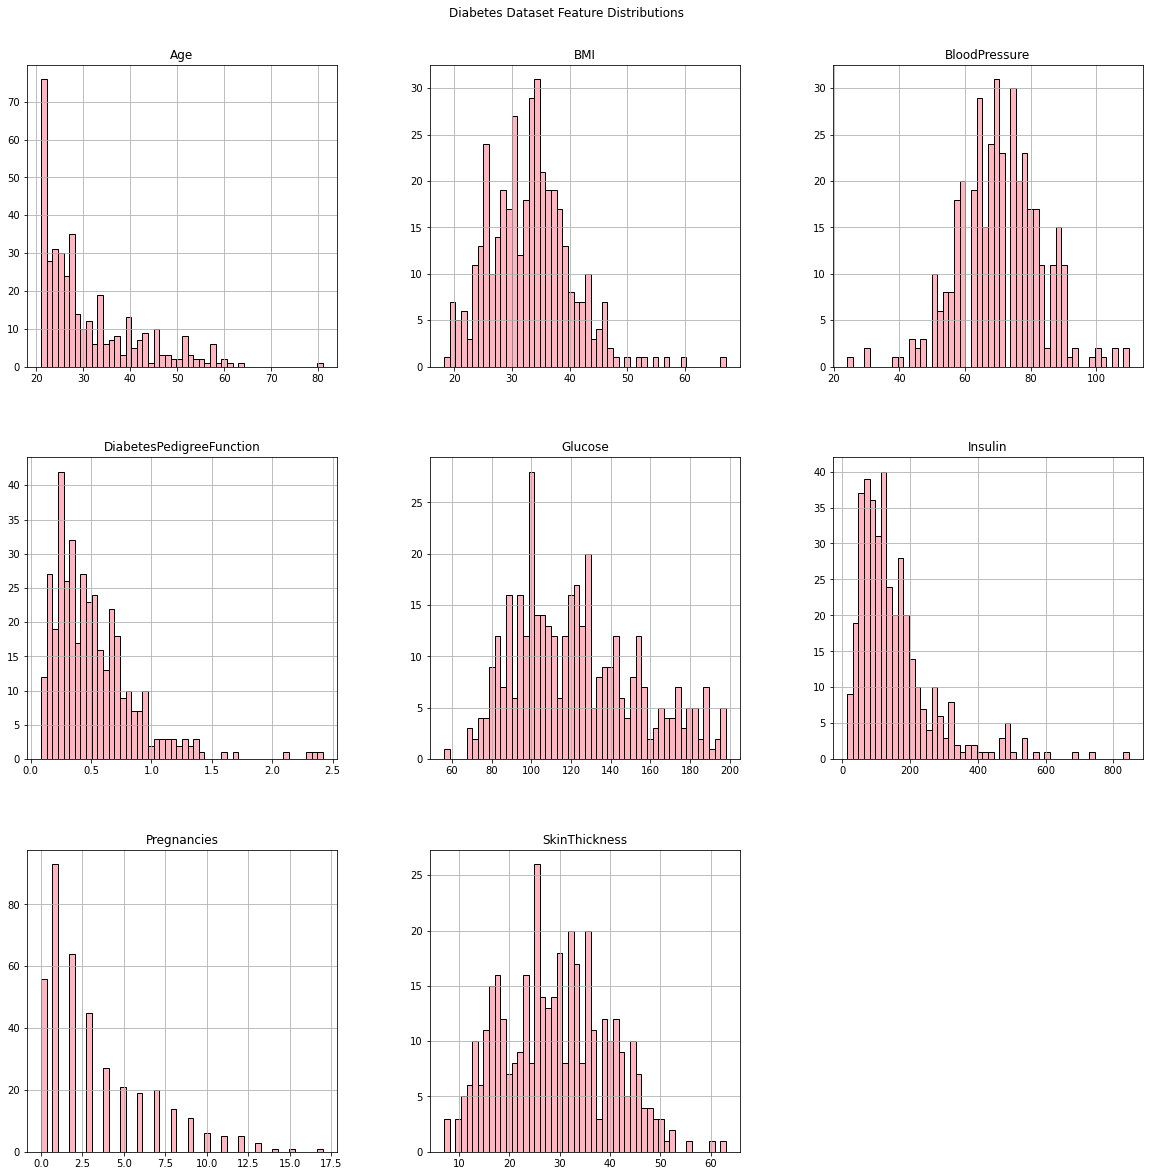

In [9]:
data.loc[:, data.columns != 'Outcome'].hist(bins=50, figsize=(20,20), color='lightpink', ec="black")
plt.suptitle('Diabetes Dataset Feature Distributions', y=0.92)

### Pie Chart 
Class Balance
- *Strong class imbalance observed*

In [10]:
class_counts = data['Outcome'].value_counts()
class_counts

0    262
1    130
Name: Outcome, dtype: int64

Text(0.5, 1.05, 'Diabetes Dataset Class Distribution')

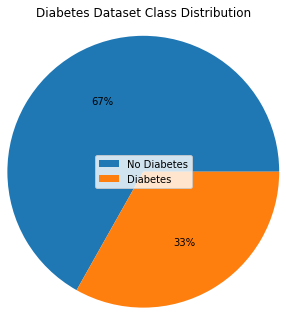

In [11]:
classes = ['No Diabetes', 'Diabetes']
plt.figure(figsize=(5, 5))
plt.pie(class_counts, autopct='%1.0f%%', radius=1.25)
plt.legend(labels=classes, loc='center')
plt.title('Diabetes Dataset Class Distribution', y=1.05)

## Data Preparation
---

In [15]:
#Train/test/val subsets
train, test = train_test_split(data, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)

In [16]:
#Separating labels from data
x_test, y_test = features_labels_split(test, 'Outcome')
x_train, y_train = features_labels_split(train, 'Outcome')
x_val, y_val = features_labels_split(val, 'Outcome')

In [17]:
#Scaling
scaler = preprocessing.MinMaxScaler() 

x_train = scaler.fit_transform(x_train) 
x_val = scaler.transform(x_val) 
x_test = scaler.transform(x_test) 

In [18]:
#Label one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [19]:
print(f'Total samples: {x_test.shape[0] + x_train.shape[0] + x_val.shape[0]}')
print(f'Testing samples: {x_test.shape[0]}') 
print(f'Training samples: {x_train.shape[0]}')
print(f'Validation samples {x_val.shape[0]}')

Total samples: 392
Testing samples: 40
Training samples: 316
Validation samples 36


## Model
---

In [40]:
#Define
model = Sequential()

model.add(Dense(units=16, input_dim=x_train.shape[1], activation='relu')) 

model.add(Dense(units=64, activation='relu', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))

model.add(Dense(units=64, activation='relu', kernel_regularizer=l1(0.001))) 
model.add(Dropout(0.3))

model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))

model.add(Dropout(0.5))
model.add(Dense(units=2, activation="softmax"))

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                1088      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)               

In [42]:
#Compile
model.compile(optimizer = Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [43]:
start = time()

history = model.fit(x_train, 
                    y_train, 
                    validation_data = (x_val, y_val),
                    epochs=300, 
                    verbose=0)

print(f'Complete. \nModel trained in {round(time()-start, 2)} sec')

Complete. 
Model trained in 8.14 sec


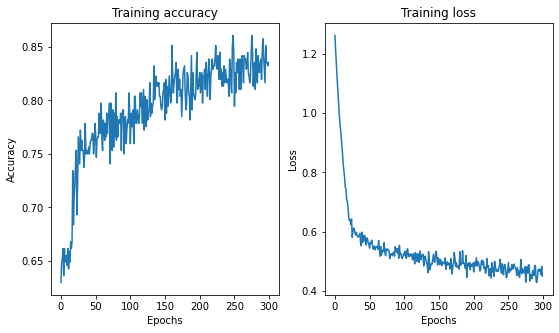


Training accuracy: 83.54%
Training loss: 0.451


In [44]:
plot_display_metrics(model, history)

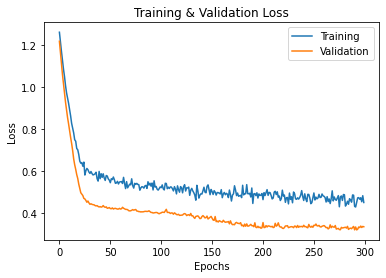


Training accuracy: 83.54%
Training loss: 0.451

Validation accuracy: 88.89%
Validation loss: 0.335


In [45]:
plot_train_val(history)

In [46]:
test_score = model.evaluate(x_test, y_test)
print(f"Testing accuracy: {round(test_score[1], 4) * 100}%")
print(f"Testing loss: {round(test_score[0], 3)}")

2/2 [==============================] - 0s 1ms/step - loss: 0.4530 - accuracy: 0.8250
Testing accuracy: 82.5%
Testing loss: 0.453


## Model Evaluation
---

### Confusion Matrix

In [47]:
#Encased in np.argmax() to convert from one-hot encoding to regular so it can work with sklearn functionality
y_pred = np.argmax(model.predict(x_test), axis=-1) 
y_true = np.argmax(y_test, axis=1)

print(np.unique(y_true)) #to check order classes appear in to correctly label confusion matrix
labels = ['No Diabetes', 'Diabetes']

[0 1]


Text(33.0, 0.5, 'True')

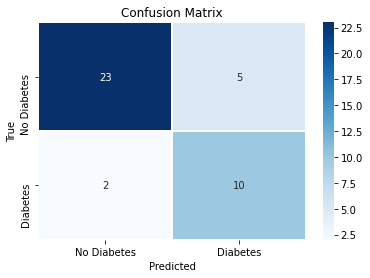

In [48]:
confusion = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion, index=labels, columns=labels)

sns.heatmap(df_cm, annot=True, linewidths=0.8, fmt='d', cmap='Blues')
plt.title('Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('True') 

In [49]:
print(f'False positives: ', confusion[0, 1])
print(f'False negatives: ', confusion[1, 0])

False positives:  5
False negatives:  2


### Model Metrics

In [50]:
print(f'Weighted Precision: {round(precision_score(y_true, y_pred, average="weighted") * 100, 2)}%')
print(f'Weighted Recall: {round(recall_score(y_true, y_pred, average="weighted") * 100, 2)}%')
print(f'Weighted F1-score: {round(f1_score(y_true, y_pred, average="weighted") * 100, 2)}%')

Weighted Precision: 84.4%
Weighted Recall: 82.5%
Weighted F1-score: 82.98%
